# Jax
### (J)ax is (A)utograd and (X)LA

* Autograd is automatic differentiation
* XLA is a machine-learning compiler*

## Table
0. Why jax?
1. `jax.numpy`
2. `jax.vmap`
3. `jax.lax.scan` (loops)
4. `jax.random`

In [2]:
import jax
import jax.numpy as jnp # jax version of numpy

In [3]:
from functools import partial
from itertools import product

In [4]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"

# Why jax?
Gradients, linear algebra, and vectorisation operations are ubiquitous in machine learning

* Jax is numpy for machine learning
* Jax is numpy +
    1. Gradients
    2. non-trivial vectorisations
    3. parallelisation
    4. speed

## A first program with jax

In [5]:
def f(x):
    return jnp.sin(x)

In [6]:
f(0.0)

Array(0., dtype=float32, weak_type=True)

## (Almost) everything we can do in numpy we can do in jax

`jax.numpy` is a drop-in replacement for `numpy`. Some examples

In [7]:
jnp.arange(10) # np.arange(10)
jnp.linspace(0, 1, 100) # np.linspace(0, 1, 100)
jnp.sin # np.sin
jnp.linalg.solve # np.linalg.solve

<PjitFunction of <function solve at 0x7fba285dc3a0>>

**Note**  
Not all we can do in jax we can do in numpy

# Gradients
For a given scalar function `f(x: array) -> float`, we can compute the *exact* gradient of `f` with respect to the first parameter in the function as
`jax.grad(f)`.
For example

In [54]:
df = jax.grad(f) # cos(x)
df(0.0) # cos(0)

Array(0., dtype=float32, weak_type=True)

**Gradients are defined for scalar-output functions.**

An important implication is that if scalar-output function is vectorisable,
the gradient of that scalar-output is not vectorisible.
This is because if we evaluate `f` using an `n`-dimensional array `xv`, then `len(f(xv)) == n`,
which would make it non-scalar.

Consider the following example for `f(x) = sin(x)`.
We can evaluate the function over a given array of values as we would in numpy

In [55]:
def f(x): return jnp.sin(x)

xv = jnp.linspace(-jnp.pi, jnp.pi, 100)
f(xv)

Array([ 8.7422784e-08, -6.3423857e-02, -1.2659244e-01, -1.8925104e-01,
       -2.5114805e-01, -3.1203350e-01, -3.7166259e-01, -4.2979503e-01,
       -4.8619670e-01, -5.4064083e-01, -5.9290773e-01, -6.4278746e-01,
       -6.9007891e-01, -7.3459160e-01, -7.7614641e-01, -8.1457585e-01,
       -8.4972537e-01, -8.8145334e-01, -9.0963197e-01, -9.3414789e-01,
       -9.5490223e-01, -9.7181165e-01, -9.8480773e-01, -9.9383849e-01,
       -9.9886733e-01, -9.9987411e-01, -9.9685478e-01, -9.8982149e-01,
       -9.7880250e-01, -9.6384221e-01, -9.4500089e-01, -9.2235434e-01,
       -8.9599377e-01, -8.6602527e-01, -8.3256984e-01, -7.9576182e-01,
       -7.5574952e-01, -7.1269429e-01, -6.6676903e-01, -6.1815906e-01,
       -5.6705993e-01, -5.1367742e-01, -4.5822650e-01, -4.0093049e-01,
       -3.4202030e-01, -2.8173247e-01, -2.2031064e-01, -1.5800147e-01,
       -9.5055975e-02, -3.1728067e-02,  3.1727828e-02,  9.5055975e-02,
        1.5800147e-01,  2.2031052e-01,  2.8173259e-01,  3.4202018e-01,
      

However, evaluating the gradient of the inputs w.r.t. the input vector would return an error
since the output is **not** scalar.

In [56]:
df = jax.grad(f)
df(xv)

TypeError: Gradient only defined for scalar-output functions. Output had shape: (100,).

# Higher order derivatives in jax
### Jacobians

In this section, we consider functions `f(x: array) -> array`

In [24]:
# jax.jacrev, jax.jacfwd, jax.hessian

# Vectorising single-output-valued functions: `jax.vmap`

To overcome the problem above, we can use the `jax.vmap` function to declare which parameters should be considered element-wise.
The function `jax.vmap` both takes and returns a function whose inputs are evaluated element-wise.

Consider a one-dimensional array `x.shape == (N,)` and a function `f`. Calling `jax.vmap(f)(x)` amounts to evaluating.
```python
jax.vmap(f)(x) = [f(x[0]), f(x[1]), ..., f(x[-1])]
```

Note that `jax.vmap(f)` is a function itself, so it's common to store this function inside a variable.

## Example
Let's consider the example above. To evaluate the gradient of `f` on all the datapoints of the array`xv`,
we define a new function `vdf` that acts *elementwise* on `df`.

In [57]:
# Vectorised derivative of f
vdf = jax.vmap(df)
vdf(xv)

Array([-1.        , -0.9979867 , -0.9919548 , -0.98192877, -0.96794873,
       -0.95007116, -0.9283679 , -0.90292645, -0.8738494 , -0.8412535 ,
       -0.8052704 , -0.7660446 , -0.72373414, -0.6785096 , -0.63055277,
       -0.580057  , -0.52722555, -0.4722711 , -0.41541502, -0.3568862 ,
       -0.29692057, -0.23575886, -0.17364842, -0.11083819, -0.04758186,
        0.01586581,  0.07925007,  0.14231463,  0.20480649,  0.26647368,
        0.32706788,  0.38634503,  0.44406658,  0.5000002 ,  0.55392003,
        0.6056097 ,  0.65486085,  0.7014747 ,  0.7452645 ,  0.78605306,
        0.8236765 ,  0.85798335,  0.88883543,  0.9161085 ,  0.9396926 ,
        0.95949304,  0.9754298 ,  0.9874389 ,  0.99547195,  0.9994965 ,
        0.9994965 ,  0.99547195,  0.9874389 ,  0.97542983,  0.959493  ,
        0.9396926 ,  0.9161085 ,  0.88883543,  0.85798335,  0.8236765 ,
        0.7860531 ,  0.7452645 ,  0.70147496,  0.65486085,  0.6056097 ,
        0.55392003,  0.49999988,  0.44406664,  0.38634515,  0.32

In the code above, calling `vdf(x)` can be thought of as calling
```python
vdf(x) = [jax.grad(f)(x[0]), jax.grad(f)(x[1]), ..., jax.grad(f)(x[-1])]
```

## Example
Plotting `f(x)` and `df(x)`.

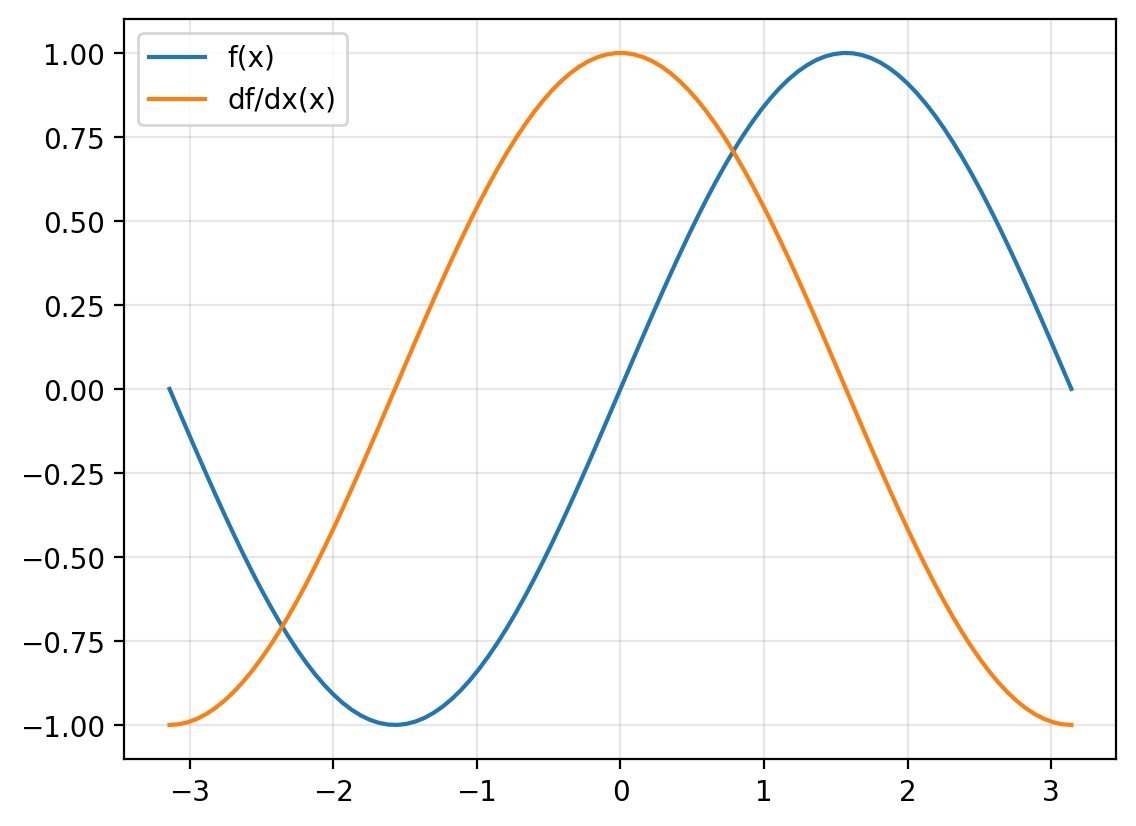

In [62]:
x = jnp.linspace(-jnp.pi, jnp.pi, 100)
plt.plot(x, f(x), label="f(x)")
plt.plot(x, vdf(x), label="df/dx(x)")
plt.legend()
plt.grid(alpha=0.3)

## practical considertions using `jax.vmap`

For a function `f(x,y,z)`, then
```python
jax.vmap(f)(x,y,z) = [f(x[0], y[0], z[0]), ..., f(x[-1], y[-1], z[-1])]
```

At times, we want to vectorise over a single parameter and treat other parameters as fixed. For the example above, suppose we seek to evaluate 
```python
[f(x[0], y, z), ..., f(x[-1], y, z)]
```

or perhaps we want to evaluate
```python
[f(x[0], y, z[0]), ..., f(x[-1], y, z[-1])]
```

Or, if `x.shape = (N, M)`, suppose we want to vectorise over the second axis to obtain
```python
[f(x[:, 0], y, z), ..., f(x[:, -1], y, z)]
```

In all cases above, we can make use of the `in_axes` parameter in `jax.vmap`.
<!-- This parameter specifies over which parameters we want to vectorise over. -->
The `in_axes` parameter, if specified, eiter takes an integer that specifies over which axes all parameters should be evaluated over (`in_axes=0` by default), or a tuple that has the same length as number of parameters in the function. In the latter case, each tuple has either an `int` indicating which axes to map over a specific parameter or `None` if the element should be taken as-is.

For the examples above, vectorising the function `f(x,y,z)` using `jax.vmap` over the first axes of the first parameter (`x`) and fixing `y` and `z` is done as
```python
jax.vmap(f)(in_axes=(0, None, None))(x, y, z) = [f(x[0], y, z), ..., f(x[-1], y, z)]
```

Vectorising `f(x,y,z)` over the first first axes of `x` and `z` and fixing `y`
```python
jax.vmap(f)(in_axes=(0, None, 0))(x, y, z) = [f(x[0], y, z[0]), ..., f(x[-1], y, z[-1])]
```

### Exercise: the density and derivative of the density for a Normally-distributed random variable

Take
$$
    f(x; \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{1}{2\sigma^2}(x - \mu)^2\right)
$$

In [63]:
def f(x, mu, sigma2):
    return 1 / jnp.sqrt(jnp.pi * sigma2) * jnp.exp(-(x - mu) ** 2 / (2 * sigma2))


df = jax.vmap(jax.grad(f), in_axes=(0, None, None))

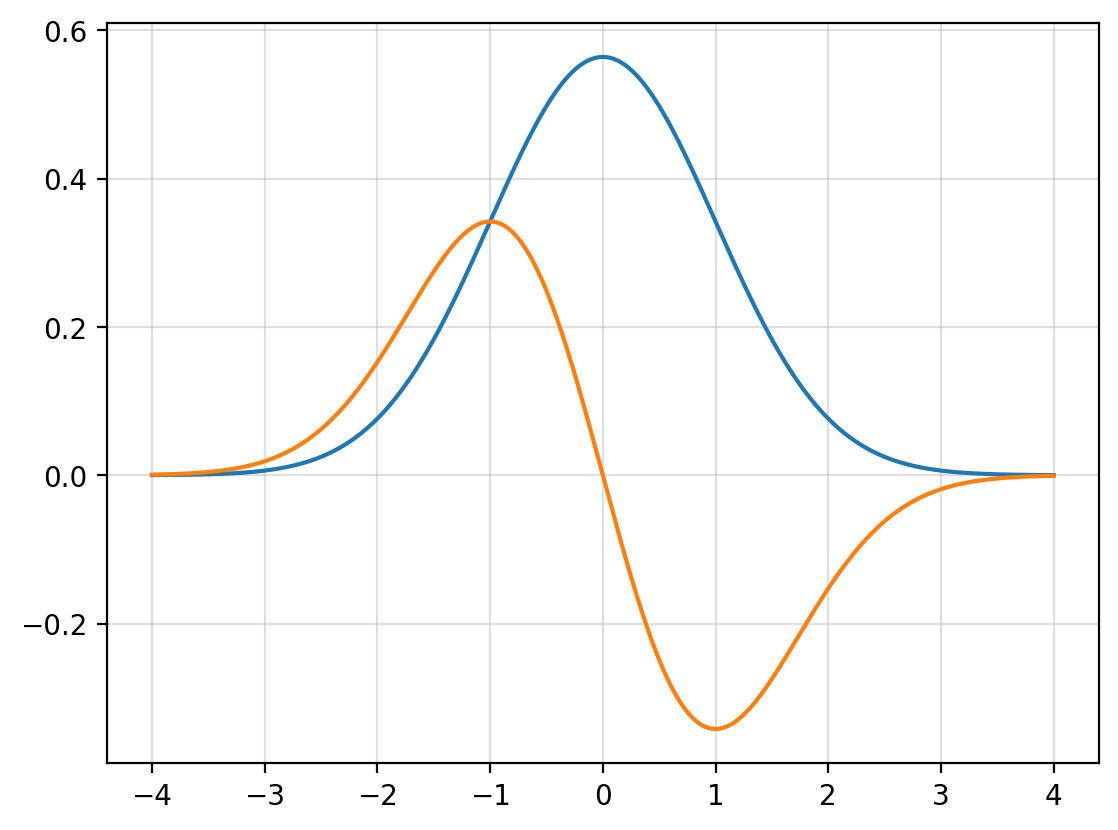

In [64]:
xrange = jnp.linspace(-4, 4, 500)
mu = 0.0
sigma2 = 1.0

plt.plot(xrange, f(xrange, mu, sigma2))
plt.plot(xrange, df(xrange, mu, sigma2))
plt.grid(alpha=0.4)

## Compositions of `jax.vmap`
Suppose we're interested in evaluating `f(x: float, mu: float, sigma:float) -> float`
using an array `xv.shape == (N,)`, `sigmav.shape==(M,)`, and fixed `mu`.
In this example, we want to obtain an `(N,M)` array such that the
`(n,m)`-th entry is given by
is given by
```python
    f(x[n], mu, sigma[m])
```

and more generally
```python
[
    [f(x[0], mu, sigma[0]), ..., f(x[0], mu, sigma[-1])],
    ...,
    [f(x[-1], mu, sigma[0]), ..., f(x[-1], mu, sigma[-1])],
]
```

To obtain the desired array above, we can use `jax.vmap`

To this using `vmap`, we can do a function composition of `vmap`. Consider the following program

```python
jax.vmap(jax.vmap(f, in_axes=(None, None, 0), in_axes=(0, None, None)))(x, mu, sigma)
= [
    jax.vmap(f, in_axes=(0, None, None)(x, mu, sigma[0]),
    ...,
    jax.vmap(f, in_axes=(0, None, None)(x, mu, sigma[-1]),
] # M calls to the function (cols)
= [
    [f(x[0], mu, sigma[0]), ..., f(x[-1], mu, sigma[0])],
    ...
    [f(x[0], mu, sigma[-1]), ..., f(x[-1], mu, sigma[-1])],
] # N x M calls to the function (rows, cols)
```

### Example
Evaluate the density of a zero-mean Gaussian for multiple standard deviations.

In [65]:
# Define composite function:
# 1. evaluate density for varying sigma2
fv = jax.vmap(f, in_axes=(None, None, 0))
# 2. evaluate density at different points of the domain
fv = jax.vmap(fv, in_axes=(0, None, None))

xrange = jnp.linspace(-4, 4, 500)
sigma_values = jnp.array([0.1, 0.5, 1.0, 5.0])

density_sigmas = fv(xrange, mu, sigma_values)
density_sigmas.shape

(500, 4)

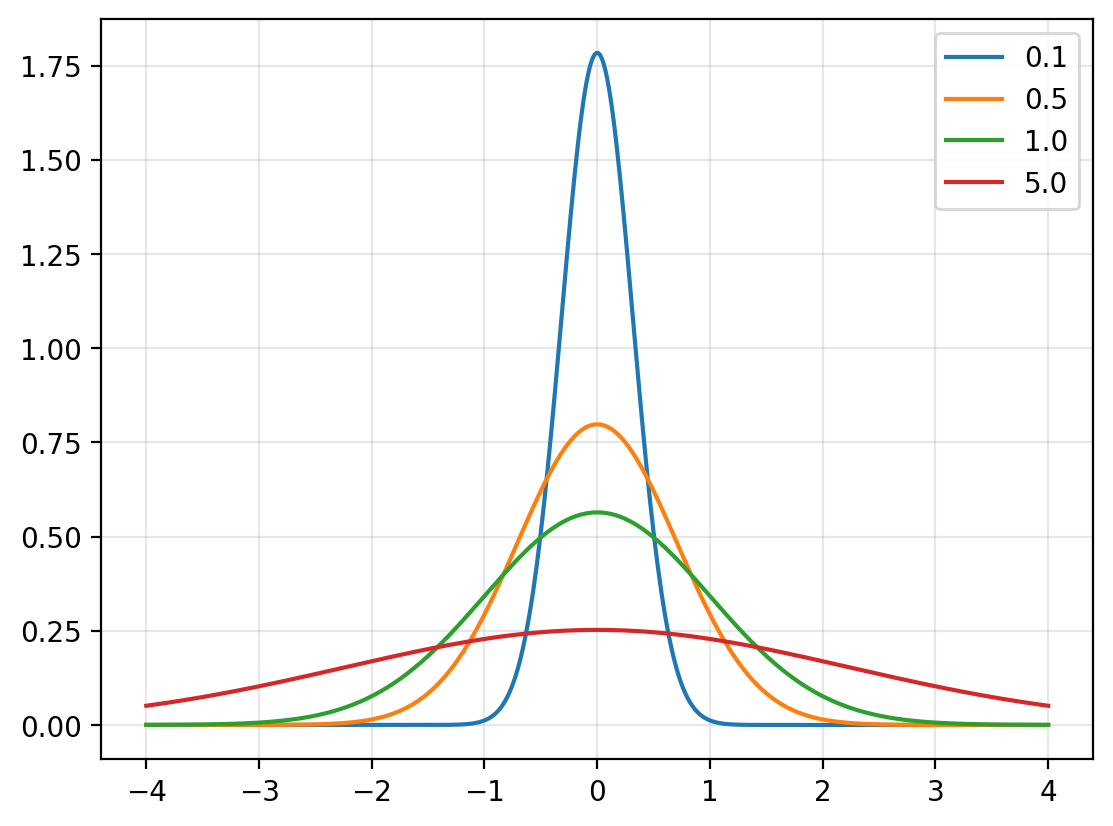

In [66]:
plt.plot(xrange, density_sigmas, label=sigma_values)
plt.legend()
plt.grid(alpha=0.3)

### Exercise:
Evaluate `df/dx` over multiple values of `sigma`, where `f` is defined in the following cell

In [67]:
def f(x, mu, sigma2):
    return 1 / jnp.sqrt(jnp.pi * sigma2) * jnp.exp(-(x - mu) ** 2 / (2 * sigma2))

In [68]:
sigma_values = jnp.array([0.3, 0.5, 1.0, 3.0])

In [69]:
dfv = jax.vmap(jax.grad(f), in_axes=(0, None, None))
dfv = jax.vmap(dfv, in_axes=(None, None, 0))

dfv(xrange, mu, sigma_values).shape

(4, 500)

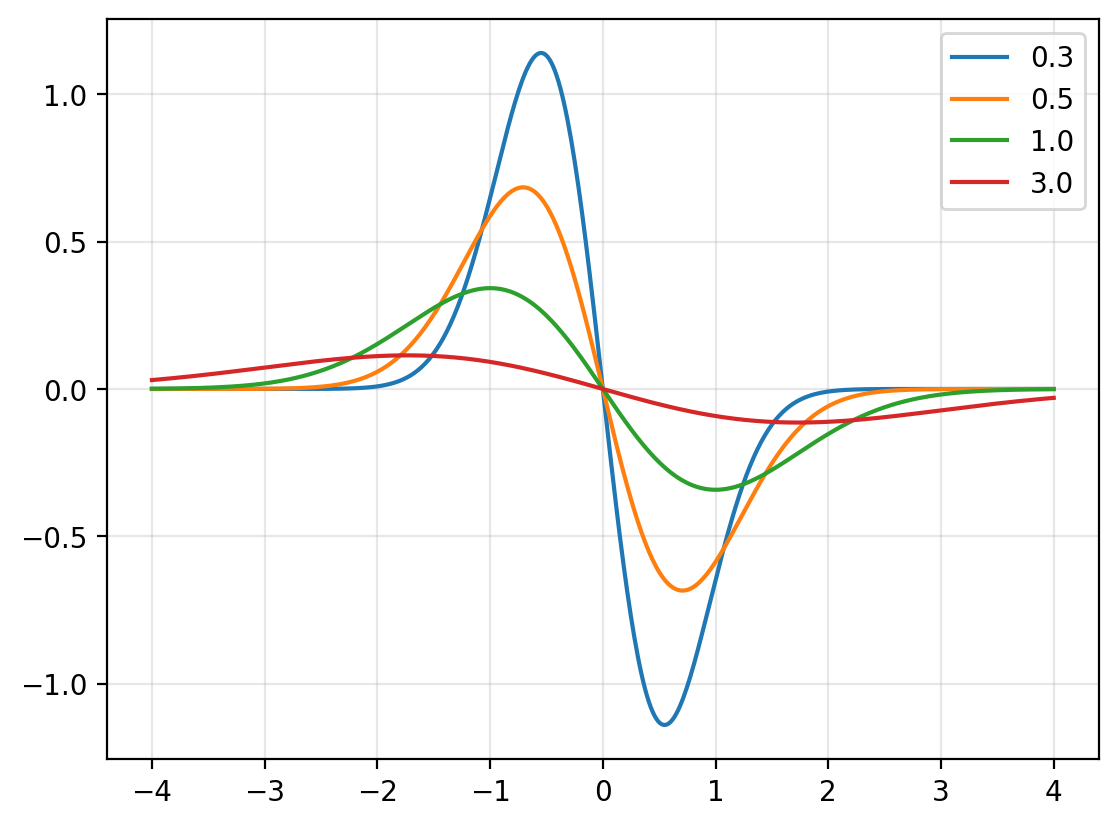

In [70]:
plt.plot(xrange, dfv(xrange, mu, sigma_values).T, label=sigma_values)
plt.legend()
plt.grid(alpha=0.3)

# (Pseudo) random numbers
**It's all about keys**

In [76]:
key = jax.random.PRNGKey(314)
jax.random.bernoulli(key)

Array(False, dtype=bool)

In [77]:
jax.random.bernoulli(key, shape=(10,))

Array([ True,  True, False,  True,  True, False,  True,  True, False,
        True], dtype=bool)

## Splitting keys
Pseudo random is not random

In [78]:
jax.random.uniform(key, shape=(10,))

Array([0.0761503 , 0.07867682, 0.709254  , 0.37048185, 0.34509873,
       0.75029814, 0.46682942, 0.36404204, 0.6340014 , 0.48699093],      dtype=float32)

In [80]:
jax.random.uniform(key, shape=(10,)) < 0.5 # compare to output above

Array([ True,  True, False,  True,  True, False,  True,  True, False,
        True], dtype=bool)

In [81]:
key0, key1 = jax.random.split(key)

In [82]:
jax.random.uniform(key0, shape=(10,))

Array([0.933166  , 0.75823843, 0.67076564, 0.590727  , 0.28587377,
       0.9774393 , 0.25147367, 0.57868946, 0.6736959 , 0.7053385 ],      dtype=float32)

In [83]:
jax.random.uniform(key1, shape=(10,))

Array([0.15635562, 0.6863278 , 0.2852882 , 0.81949353, 0.24282789,
       0.6552634 , 0.5241293 , 0.54633987, 0.8736408 , 0.6827489 ],      dtype=float32)

### Sampling

In [84]:
jax.random.multivariate_normal
jax.random.normal
jax.random.uniform
jax.random.gamma
jax.random.bernoulli
jax.random.poisson
jax.random.choice

<function jax._src.random.choice(key: Union[jax.Array, jax._src.prng.PRNGKeyArray], a: Union[int, jax.Array, numpy.ndarray, numpy.bool_, numpy.number, bool, float, complex], shape: Sequence[int] = (), replace: bool = True, p: Union[jax.Array, numpy.ndarray, numpy.bool_, numpy.number, bool, int, float, complex, NoneType] = None, axis: int = 0) -> jax.Array>

### Stochastic processes

In [85]:
def stopfn(entry):
    _, v = entry
    x, y = v
    return (x == 5) * (y == 4)

In [86]:
def step_grid(entry):
    key, v = entry
    vals = jnp.array([-1, 1])
    v = v + jax.random.choice(key, vals, shape=(2,))
    return v, key

# Making Jax go brr
In this section, we introduce jax tools to make
high performing and parallel code.

## Just-in-time compiler

In [87]:
@jax.jit
def f(x):
    return  x ** 2

jax.make_jaxpr(f)(1.0)

{ lambda ; a:f32[]. let
    b:f32[] = pjit[
      jaxpr={ lambda ; c:f32[]. let d:f32[] = integer_pow[y=2] c in (d,) }
      name=f
    ] a
  in (b,) }

In [88]:
def step_fn(x, _):
    x_new = x - alpha * df(x)
    carry = x_new
    return x_new, None

@jax.jit
@partial(jax.vmap, in_axes=0)
def find_min(x0):
    v, _ = jax.lax.scan(step_fn, x0, steps)
    return v

In [148]:
D = 5_000
n_samples = 100_000
A = jax.random.uniform(key, shape=(D, D), minval=-3, maxval=3)
x0_vals = jax.random.uniform(key, shape=(n_samples, D), minval=-3, maxval=3)

In [149]:
@jax.vmap
def mdistance(x):
    return x.T @ A @ x
distance = mdistance(x0_vals)

mdistance_jit = jax.jit(mdistance)
mdistance_jit(x0_vals);

In [150]:
%%timeit -n 20 -r 10 -o
distance = mdistance(x0_vals)

101 ms ± 14.2 ms per loop (mean ± std. dev. of 10 runs, 20 loops each)


<TimeitResult : 101 ms ± 14.2 ms per loop (mean ± std. dev. of 10 runs, 20 loops each)>

In [151]:
t0 = _.average

In [152]:
%%timeit -n 20 -r 10 -o
distance = jax.block_until_ready(mdistance_jit(x0_vals))

94.7 ms ± 10.5 ms per loop (mean ± std. dev. of 10 runs, 20 loops each)


<TimeitResult : 94.7 ms ± 10.5 ms per loop (mean ± std. dev. of 10 runs, 20 loops each)>

In [153]:
t1 = _.average

In [154]:
pct_speedup = t0 / t1 - 1
format(pct_speedup, "0.2%")

'6.69%'

## Faster

In [155]:
jax.debug.visualize_array_sharding(x0_vals)

         
         
         
         
         
  TPU 0  
         
         
         
         
         

In [156]:
devices = jax.devices()
devices

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [157]:
sharding = jax.sharding.PositionalSharding(devices)
sharding

PositionalSharding([{TPU 0} {TPU 1} {TPU 2} {TPU 3} {TPU 4} {TPU 5} {TPU 6} {TPU 7}])

In [158]:
x0_vals = jax.device_put(x0_vals, sharding.reshape(8, 1))

In [159]:
jax.debug.visualize_array_sharding(x0_vals)

  TPU 0  
         
  TPU 1  
         
  TPU 2  
         
  TPU 3  
         
  TPU 4  
         
  TPU 5  
         
  TPU 6  
         
  TPU 7  
         

In [169]:
%%timeit -n 20 -r 10 -o
distance = jax.block_until_ready(mdistance_jit(x0_vals))

12.4 ms ± 73.3 µs per loop (mean ± std. dev. of 10 runs, 20 loops each)


<TimeitResult : 12.4 ms ± 73.3 µs per loop (mean ± std. dev. of 10 runs, 20 loops each)>

In [170]:
t2 = _.average

In [171]:
pct_speedup = t0 / t2 - 1
format(pct_speedup, "0.2%")

'715.34%'

In [172]:
pct_speedup = t1 / t2 - 1
format(pct_speedup, "0.2%") # expected ~ 800% speedup. Milleage may vary

'664.24%'

# Loops in jax: `scan`, `for`, and `while`

## `jax.lax.scan`

Pseudocode
```python
jax.lax.scan(f, init, xs)

v = init
hist = [] # optional
for x in xs:
    v, g = f(v, x)
    hist.append(g)
return v, hist
```

### Example: first-order optimisation of a non-linear function

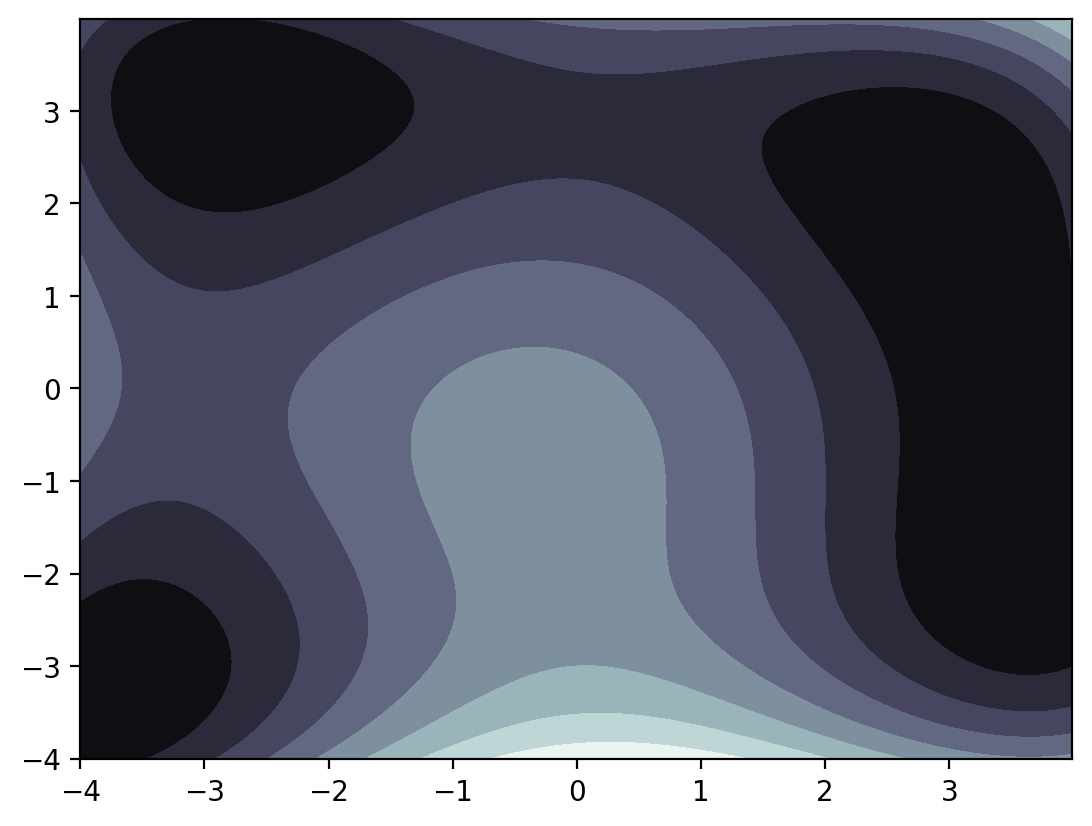

In [71]:
def f(v):
    x, y = v
    return (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2

X = jnp.mgrid[-4:4:0.01, -4:4:0.01]
plt.contourf(*X, f(X), cmap="bone")

In [72]:
alpha = 1e-3
df = jax.grad(f)
def step_fn(x, _):
    x_new = x - alpha * df(x)
    carry = x_new
    return x_new, carry

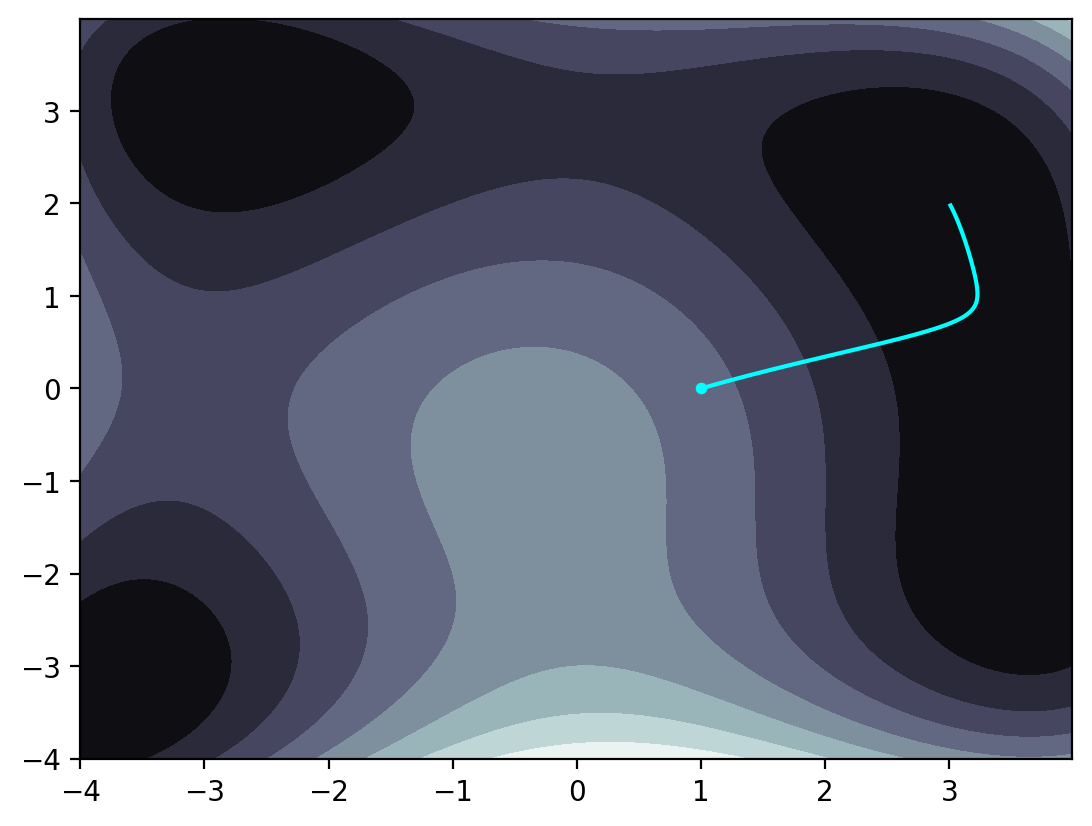

In [73]:
x0 = jnp.array([1.0, 0.0])
steps = jnp.arange(250)
x_final, hist = jax.lax.scan(step_fn, x0, steps)

plt.contourf(*X, f(X), cmap="bone")
plt.scatter(*x0, c="cyan", s=10)
plt.plot(*hist.T, c="cyan")

### Exampe: Vmap-composed scanned

In [74]:
@partial(jax.vmap, in_axes=0)
def find_path(x0):
    _, hist = jax.lax.scan(step_fn, x0, steps)
    return hist

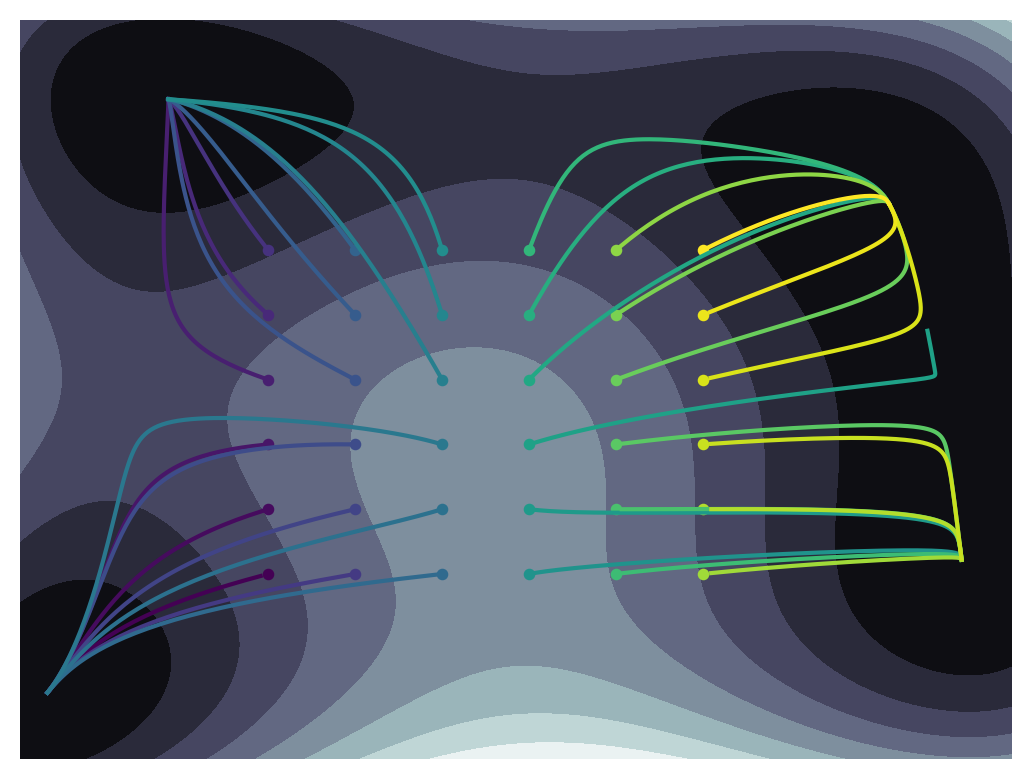

In [75]:
arr = jnp.array(jnp.linspace(-2, 1.5, 6))
x0_vals = jnp.array([(i, j) for i, j in product(arr, arr)])

colors = plt.cm.viridis(jnp.linspace(0, 1, len(x0_vals)))
plt.contourf(*X, f(X), cmap="bone")
paths = find_path(x0_vals)
for color, path, x0 in zip(colors, paths, x0_vals):
    plt.scatter(*x0, s=10, color=color)
    plt.plot(*path.T, c=color)
plt.axis("off");